In [46]:
import os
import cv2
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import feature
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [47]:
print("\nROI definido:")
roi_crop = {
    'x1_pct': 0.05,
    'y1_pct': 0.05,
    'x2_pct': 0.95,
    'y2_pct': 0.95,
}

area_conservada = ((roi_crop['x2_pct'] - roi_crop['x1_pct']) * 
                    (roi_crop['y2_pct'] - roi_crop['y1_pct']))

print(f"   ROI: X[{roi_crop['x1_pct']:.1%} - {roi_crop['x2_pct']:.1%}], "
        f"Y[{roi_crop['y1_pct']:.1%} - {roi_crop['y2_pct']:.1%}]")
print(f"   Área conservada: {area_conservada:.2%}")


ROI definido:
   ROI: X[5.0% - 95.0%], Y[5.0% - 95.0%]
   Área conservada: 81.00%


In [48]:
def visualize_roi(input_path, roi_crop, n_examples=9, save_path='roi_visualization.png'):
    """Visualiza el ROI en ejemplos aleatorios"""
    img_files = list(Path(input_path).rglob('*.png'))
    samples = np.random.choice(img_files, min(n_examples, len(img_files)), replace=False)
    
    rows = 2
    cols = n_examples
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    
    for idx, img_path in enumerate(samples):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        x1 = int(roi_crop['x1_pct'] * w)
        y1 = int(roi_crop['y1_pct'] * h)
        x2 = int(roi_crop['x2_pct'] * w)
        y2 = int(roi_crop['y2_pct'] * h)
        
        img_with_roi = img_rgb.copy()
        cv2.rectangle(img_with_roi, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        img_cropped = img_rgb[y1:y2, x1:x2]
        
        axes[0, idx].imshow(img_with_roi)
        axes[0, idx].set_title(f'Original\n{w}×{h}', fontsize=8)
        axes[0, idx].axis('off')
        
        axes[1, idx].imshow(img_cropped)
        axes[1, idx].set_title(f'Recortada\n{x2-x1}×{y2-y1}', fontsize=8)
        axes[1, idx].axis('off')
    
    plt.suptitle('Visualización del ROI Propuesto', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

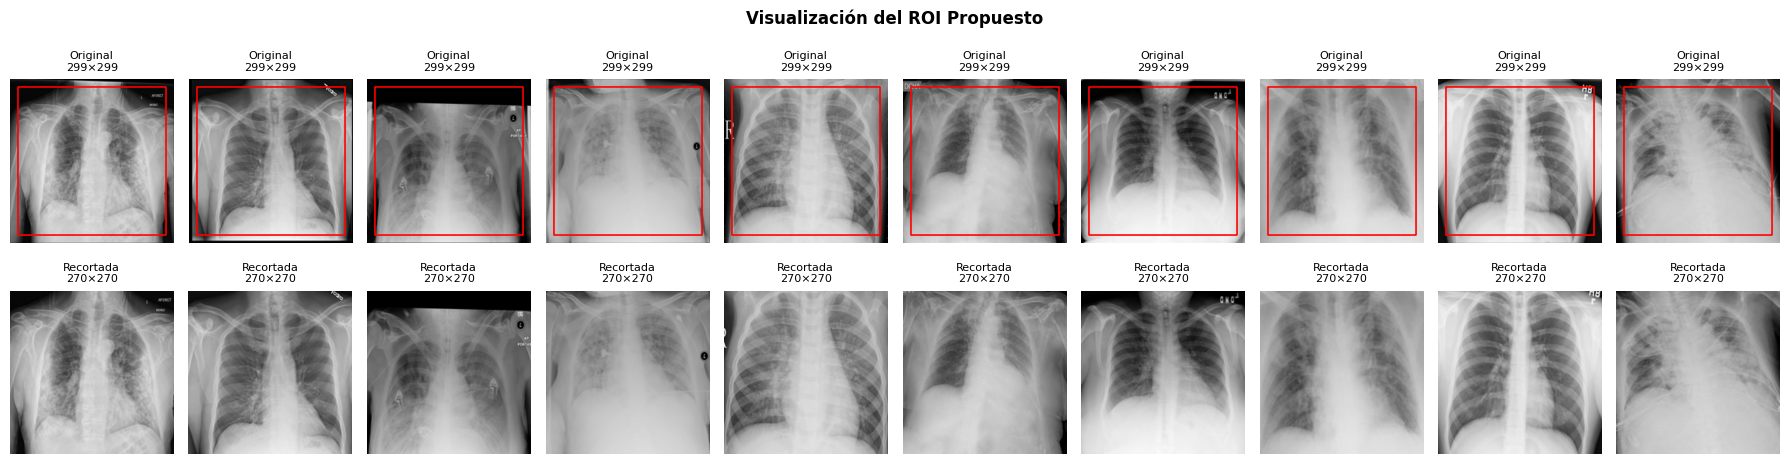

In [49]:
visualize_roi('COVID-19_Radiography_Dataset', roi_crop, n_examples=10)

In [50]:
def preprocess_image(img, roi_crop, target_size=(128, 128)):
    """
    Pipeline: ROI → Grayscale → CLAHE → Denoise → Resize
    """
    h, w = img.shape[:2]
    
    # 1. Recortar ROI
    x1 = int(roi_crop['x1_pct'] * w)
    y1 = int(roi_crop['y1_pct'] * h)
    x2 = int(roi_crop['x2_pct'] * w)
    y2 = int(roi_crop['y2_pct'] * h)
    
    img_cropped = img[y1:y2, x1:x2]
    
    # 2. Convertir a grayscale
    gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    
    # 3. Aplica CLAHE 
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(gray)
    
    # 4. Gaussian blur suave para reducir ruido
    img_smooth = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    
    # 5. Redimensionar
    img_resized = cv2.resize(img_smooth, target_size, interpolation=cv2.INTER_AREA)
    
    return img_resized

In [51]:
def process_single_image(args):
    """Worker function para procesamiento paralelo"""
    input_path, output_path, roi_crop, target_size = args
    
    try:
        img = cv2.imread(input_path)
        if img is None:
            return False, "No se pudo leer"
        
        img_processed = preprocess_image(img, roi_crop, target_size)
        
        # Guardar con compresión
        cv2.imwrite(output_path, img_processed, [cv2.IMWRITE_PNG_COMPRESSION, 9])
        return True, None
        
    except Exception as e:
        return False, str(e)

In [52]:
def visualize_preprocessing_steps(dataset_path, roi_crop, target_size=(128, 128), n_examples=5):
    # Buscar imágenes de ejemplo
    img_files = list(Path(dataset_path).rglob('*.png'))
    samples = np.random.choice(img_files, min(n_examples, len(img_files)), replace=False)
    
    # Crear figura
    fig, axes = plt.subplots(n_examples, 6, figsize=(18, 3*n_examples))
    
    if n_examples == 1:
        axes = axes.reshape(1, -1)
    
    titles = ['1. Original', '2. ROI Crop', '3. Grayscale', '4. CLAHE', '5. Blur', '6. Resized']
    
    for idx, img_path in enumerate(samples):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        h, w = img.shape[:2]
        
        # Paso 0: Original
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].axis('off')
        if idx == 0:
            axes[idx, 0].set_title(titles[0], fontweight='bold')
        
        # Paso 1: ROI Crop
        x1 = int(roi_crop['x1_pct'] * w)
        y1 = int(roi_crop['y1_pct'] * h)
        x2 = int(roi_crop['x2_pct'] * w)
        y2 = int(roi_crop['y2_pct'] * h)
        img_cropped = img[y1:y2, x1:x2]
        img_cropped_rgb = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
        axes[idx, 1].imshow(img_cropped_rgb)
        axes[idx, 1].axis('off')
        if idx == 0:
            axes[idx, 1].set_title(titles[1], fontweight='bold')
        
        # Paso 2: Grayscale
        gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
        axes[idx, 2].imshow(gray, cmap='gray')
        axes[idx, 2].axis('off')
        if idx == 0:
            axes[idx, 2].set_title(titles[2], fontweight='bold')
        
        # Paso 3: CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(gray)
        axes[idx, 3].imshow(img_clahe, cmap='gray')
        axes[idx, 3].axis('off')
        if idx == 0:
            axes[idx, 3].set_title(titles[3], fontweight='bold')
        
        # Paso 4: Blur
        img_smooth = cv2.GaussianBlur(img_clahe, (3, 3), 0)
        axes[idx, 4].imshow(img_smooth, cmap='gray')
        axes[idx, 4].axis('off')
        if idx == 0:
            axes[idx, 4].set_title(titles[4], fontweight='bold')
        
        # Paso 5: Resized
        img_resized = cv2.resize(img_smooth, target_size, interpolation=cv2.INTER_AREA)
        axes[idx, 5].imshow(img_resized, cmap='gray')
        axes[idx, 5].axis('off')
        if idx == 0:
            axes[idx, 5].set_title(titles[5], fontweight='bold')
        
        # Etiqueta de ejemplo
        axes[idx, 0].text(-0.1, 0.5, f'Ejemplo {idx+1}', 
                         transform=axes[idx, 0].transAxes,
                         fontsize=10, fontweight='bold',
                         va='center', ha='right', rotation=90)
    
    plt.suptitle('Pipeline de Preprocesamiento - Visualización', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [53]:
def preprocess_dataset(input_path, output_path, roi_crop, target_size=(128, 128), n_workers=None):
    """Preprocesa todo el dataset"""
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    img_files = list(Path(input_path).rglob('*.png'))
    
    print(f"\nPreprocesando {len(img_files)} imágenes")
    print(f"   ROI: X[{roi_crop['x1_pct']:.1%} - {roi_crop['x2_pct']:.1%}], "
          f"Y[{roi_crop['y1_pct']:.1%} - {roi_crop['y2_pct']:.1%}]")
    print(f"   Target size: {target_size}")
    
    args_list = []
    for img_path in img_files:
        relative_path = img_path.relative_to(input_path)
        output_file = Path(output_path) / relative_path
        output_file.parent.mkdir(parents=True, exist_ok=True)
        
        args_list.append((
            str(img_path),
            str(output_file),
            roi_crop,
            target_size
        ))
    
    if n_workers is None:
        n_workers = min(32, os.cpu_count() * 4)
    
    success_count = 0
    error_count = 0
    
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(tqdm(
            executor.map(process_single_image, args_list),
            total=len(args_list),
            desc="Procesando",
            unit="img"
        ))
    
    for success, error in results:
        if success:
            success_count += 1
        else:
            error_count += 1
    
    print(f"\nPreprocesamiento completado:")
    print(f"   Exitosas: {success_count}")
    print(f"   Errores: {error_count}\n")

In [54]:
preprocess_dataset(input_path='COVID-19_Radiography_Dataset', 
                   output_path='Imgs_preprocessed', 
                   roi_crop=roi_crop, 
                   target_size=(128, 128))


Preprocesando 21165 imágenes
   ROI: X[5.0% - 95.0%], Y[5.0% - 95.0%]
   Target size: (128, 128)


Procesando: 100%|██████████| 21165/21165 [00:12<00:00, 1756.38img/s]


Preprocesamiento completado:
   Exitosas: 21165
   Errores: 0



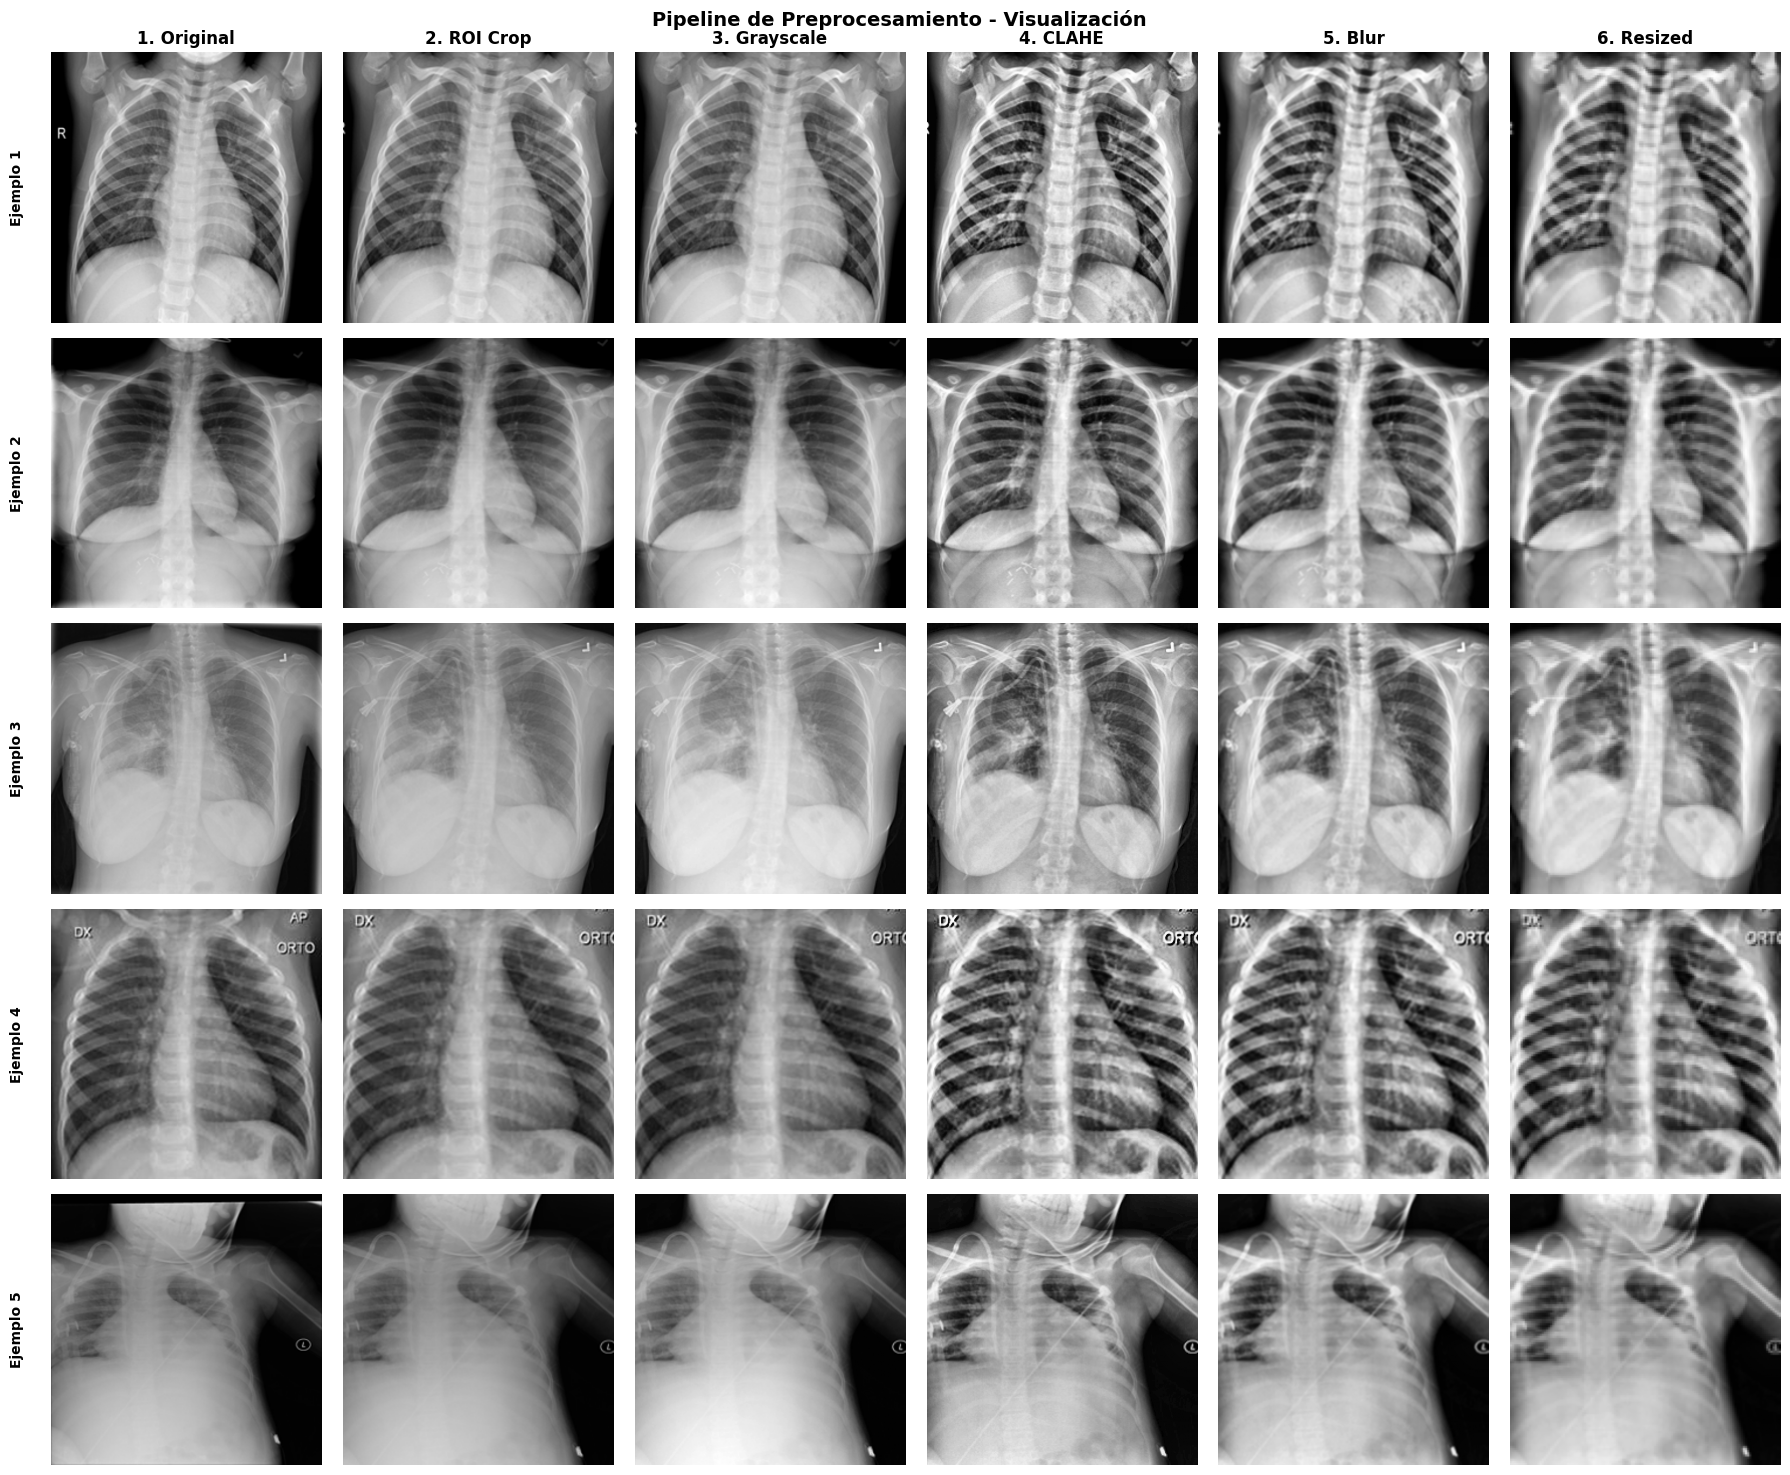

In [55]:
visualize_preprocessing_steps('COVID-19_Radiography_Dataset', roi_crop, n_examples=5)

In [56]:
def analyze_class_balance(preprocessed_path):
    """Analiza la distribución de clases"""
    class_dirs = [d for d in Path(preprocessed_path).iterdir() if d.is_dir()]
    
    class_counts = {}
    for class_dir in sorted(class_dirs):
        class_name = class_dir.name
        img_files = list(class_dir.glob('*.png'))
        count = len(img_files)
        class_counts[class_name] = count
    
    total = sum(class_counts.values())
    max_count = max(class_counts.values())
    
    print(f"\nTotal de imágenes: {total}")
    print(f"\nDistribución por clase:")
    print("-"*70)
    print(f"{'Clase':<25} {'Cantidad':<12} {'Porcentaje':<12} {'Diferencia':<12}")
    print("-"*70)
    
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100
        diff = max_count - count
        print(f"{class_name:<25} {count:<12} {percentage:<11.2f}% {diff:<12}")
    
    print("-"*70)
    
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count
    
    print(f"Clase más grande: {max_count} imágenes")
    print(f"Clase más pequeña: {min_count} imágenes")
    print(f"Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 1.5:
        print(f"\nDESBALANCE DETECTADO (ratio > 1.5:1)")
        print(f"   Se recomienda aplicar data augmentation")
    else:
        print(f"\nDataset relativamente balanceado")
    
    return class_counts, max_count


In [57]:
class_counts, max_count = analyze_class_balance(preprocessed_path='Imgs_preprocessed')


Total de imágenes: 40768

Distribución por clase:
----------------------------------------------------------------------
Clase                     Cantidad     Porcentaje   Diferencia  
----------------------------------------------------------------------
COVID                     10192        25.00      % 0           
Lung_Opacity              10192        25.00      % 0           
Normal                    10192        25.00      % 0           
Viral Pneumonia           10192        25.00      % 0           
----------------------------------------------------------------------
Clase más grande: 10192 imágenes
Clase más pequeña: 10192 imágenes
Ratio de desbalance: 1.00:1

Dataset relativamente balanceado


In [58]:
def augment_image(img, augmentation_type):
    """Aplica transformación a una imagen"""
    h, w = img.shape[:2]
    
    if augmentation_type == 'rotate_left':
        matrix = cv2.getRotationMatrix2D((w/2, h/2), 10, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'rotate_right':
        matrix = cv2.getRotationMatrix2D((w/2, h/2), -10, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'flip':
        return cv2.flip(img, 1)
    
    elif augmentation_type == 'translate':
        tx = int(w * 0.05 * np.random.choice([-1, 1]))
        ty = int(h * 0.05 * np.random.choice([-1, 1]))
        matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'zoom_in':
        new_h, new_w = int(h * 1.05), int(w * 1.05)
        img_zoomed = cv2.resize(img, (new_w, new_h))
        start_y = (new_h - h) // 2
        start_x = (new_w - w) // 2
        return img_zoomed[start_y:start_y+h, start_x:start_x+w]
    
    elif augmentation_type == 'zoom_out':
        new_h, new_w = int(h * 0.95), int(w * 0.95)
        img_zoomed = cv2.resize(img, (new_w, new_h))
        top = (h - new_h) // 2
        bottom = h - new_h - top
        left = (w - new_w) // 2
        right = w - new_w - left
        return cv2.copyMakeBorder(img_zoomed, top, bottom, left, right, cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'brightness_up':
        return np.clip(img * 1.1, 0, 255).astype(np.uint8)
    
    elif augmentation_type == 'brightness_down':
        return np.clip(img * 0.9, 0, 255).astype(np.uint8)
    
    return img

In [59]:
def balance_dataset(preprocessed_path, class_counts, target_count):
    """Balancea el dataset usando data augmentation"""
    augmentation_types = [
        'rotate_left', 'rotate_right', 'flip', 'translate',
        'zoom_in', 'zoom_out', 'brightness_up', 'brightness_down'
    ]
    
    total_generated = 0
    
    for class_name, current_count in class_counts.items():
        if current_count >= target_count:
            print(f"\n{class_name}: Ya tiene suficientes imágenes ({current_count})")
            continue
        
        needed = target_count - current_count
        print(f"\n{class_name}: Generando {needed} imágenes adicionales...")
        
        class_dir = Path(preprocessed_path) / class_name
        existing_files = list(class_dir.glob('*.png'))
        
        max_idx = 0
        for f in existing_files:
            try:
                idx = int(f.stem.split('-')[1])
                max_idx = max(max_idx, idx)
            except:
                continue
        
        generated = 0
        attempts = 0
        max_attempts = needed * 10
        
        with tqdm(total=needed, desc=f"  {class_name}", unit="img") as pbar:
            while generated < needed and attempts < max_attempts:
                attempts += 1
                
                source_img_path = np.random.choice(existing_files)
                img = cv2.imread(str(source_img_path), cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    continue
                
                aug_type = np.random.choice(augmentation_types)
                img_aug = augment_image(img, aug_type)
                
                new_idx = max_idx + generated + 1
                new_filename = f"{class_name}-{new_idx}.png"
                new_path = class_dir / new_filename
                
                cv2.imwrite(str(new_path), img_aug, [cv2.IMWRITE_PNG_COMPRESSION, 9])
                
                generated += 1
                total_generated += 1
                pbar.update(1)
        
        print(f"Generadas {generated} imágenes para {class_name}")
    
    print(f"\nData augmentation completado:")
    print(f"Total de imágenes generadas: {total_generated}")
    
    # Verificar nuevo balance
    print("Balance después de augmentation")

    new_class_counts = {}
    for class_name in class_counts.keys():
        class_dir = Path(preprocessed_path) / class_name
        new_count = len(list(class_dir.glob('*.png')))
        new_class_counts[class_name] = new_count
    
    total = sum(new_class_counts.values())
    print(f"\nTotal de imágenes: {total}")
    print(f"\nDistribución por clase:")
    print("-"*70)
    print(f"{'Clase':<25} {'Antes':<12} {'Después':<12} {'Incremento':<12}")
    print("-"*70)
    
    for class_name in sorted(new_class_counts.keys()):
        before = class_counts[class_name]
        after = new_class_counts[class_name]
        increment = after - before
        print(f"{class_name:<25} {before:<12} {after:<12} +{increment:<11}")
    
    return new_class_counts

In [60]:
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count

if imbalance_ratio > 1.5:
    print(f"\nBalanceando dataset\n")
    
    target_count = max_count

    print(f"Target: {target_count} imágenes por clase")
    
    class_counts = balance_dataset(preprocessed_path='Imgs_preprocessed', class_counts=class_counts, target_count=target_count)
else:
    print(f"Dataset balanceado\n")


Dataset balanceado



In [61]:
def create_raw_pixel_dataset(input_path, output_prefix='covid19_raw'):
    """
    Crea dataset con normalización Z-score
    """
    img_files = list(Path(input_path).rglob('*.png'))
    
    print(f"   Procesando {len(img_files)} imágenes...")
    
    images = []
    labels = []
    
    for img_path in tqdm(img_files, desc="Cargando imágenes"):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Normalización Z-score por imagen
        img_mean = img.mean()
        img_std = img.std()
        
        if img_std > 0:
            img_norm = (img.astype('float32') - img_mean) / img_std
        else:
            img_norm = img.astype('float32') - img_mean
        
        img_flat = img_norm.flatten()
        
        label = img_path.parent.name
        
        images.append(img_flat)
        labels.append(label)
    
    X = np.array(images, dtype='float32')
    y = np.array(labels)
    
    # Aplicar StandardScaler a nivel dataset
    print("\nAplicando StandardScaler a nivel dataset")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Guardar
    np.save(f'{output_prefix}_X.npy', X_scaled)
    np.save(f'{output_prefix}_y.npy', y)
    joblib.dump(scaler, f'{output_prefix}_scaler.pkl')
    
    print(f"\nDataset guardado:")
    print(f"   {output_prefix}_X.npy: {X_scaled.shape} ({X_scaled.nbytes/1024**2:.1f} MB)")
    print(f"   {output_prefix}_y.npy: {y.shape}")
    print(f"   {output_prefix}_scaler.pkl: Guardado")
    
    print(f"\n   Distribución de clases:")
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label}: {count}")
    
    return X_scaled, y

In [62]:
def split_train_val_test_numpy(X, y, output_prefix, val_size=0.15, test_size=0.15, random_state=42):
    """Split train/validation/test estratificado"""
    print("SPLIT: TRAIN / VALIDATION / TEST")
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    val_size_adjusted = val_size / (1 - test_size)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size_adjusted,
        random_state=random_state,
        stratify=y_temp
    )
    
    # Guardar
    np.save(f'{output_prefix}_X_train.npy', X_train)
    np.save(f'{output_prefix}_X_val.npy', X_val)
    np.save(f'{output_prefix}_X_test.npy', X_test)
    np.save(f'{output_prefix}_y_train.npy', y_train)
    np.save(f'{output_prefix}_y_val.npy', y_val)
    np.save(f'{output_prefix}_y_test.npy', y_test)
    
    total = len(y)
    print(f"\nSplit completado:")
    print(f"   Total: {total} muestras")
    print(f"\n   Train:      {X_train.shape} ({len(y_train):5d} = {len(y_train)/total*100:5.1f}%)")
    print(f"   Validation: {X_val.shape} ({len(y_val):5d} = {len(y_val)/total*100:5.1f}%)")
    print(f"   Test:       {X_test.shape} ({len(y_test):5d} = {len(y_test)/total*100:5.1f}%)")
    
    print(f"\n   Distribución Train:")
    unique, counts = np.unique(y_train, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label:<25} {count}")
    
    print(f"\n   Distribución Validation:")
    unique, counts = np.unique(y_val, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label:<25} {count}")
    
    print(f"\n   Distribución Test:")
    unique, counts = np.unique(y_test, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label:<25} {count}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [63]:
val_size=0.15
test_size=0.15
random_state=42

X_raw, y_raw = create_raw_pixel_dataset(input_path='Imgs_preprocessed', output_prefix='covid19_raw')
split_train_val_test_numpy(X_raw, y_raw, 'covid19_raw', val_size, test_size, random_state)

   Procesando 40768 imágenes...


Cargando imágenes: 100%|██████████| 40768/40768 [02:09<00:00, 314.01it/s]



Aplicando StandardScaler a nivel dataset

Dataset guardado:
   covid19_raw_X.npy: (40768, 16384) (2548.0 MB)
   covid19_raw_y.npy: (40768,)
   covid19_raw_scaler.pkl: Guardado

   Distribución de clases:
      COVID: 10192
      Lung_Opacity: 10192
      Normal: 10192
      Viral Pneumonia: 10192
SPLIT: TRAIN / VALIDATION / TEST

Split completado:
   Total: 40768 muestras

   Train:      (28536, 16384) (28536 =  70.0%)
   Validation: (6116, 16384) ( 6116 =  15.0%)
   Test:       (6116, 16384) ( 6116 =  15.0%)

   Distribución Train:
      COVID                     7134
      Lung_Opacity              7134
      Normal                    7134
      Viral Pneumonia           7134

   Distribución Validation:
      COVID                     1529
      Lung_Opacity              1529
      Normal                    1529
      Viral Pneumonia           1529

   Distribución Test:
      COVID                     1529
      Lung_Opacity              1529
      Normal                    1529
 

(array([[-1.1301343e-01, -6.5940060e-02,  7.9988047e-02, ...,
         -1.2651193e+00, -1.1584160e+00, -1.0568243e+00],
        [-3.0650428e-01, -2.3403157e-01, -2.6217112e-01, ...,
          1.0004444e+00,  1.1233110e+00,  1.2552387e+00],
        [ 1.4371814e+00,  1.4287852e+00,  1.5829809e+00, ...,
          3.7612957e-01,  3.5402466e-02, -2.9284239e-01],
        ...,
        [ 2.8605850e+00,  1.5298225e+00,  1.0848457e+00, ...,
         -1.9597012e-01, -7.2299950e-02,  1.6436041e-03],
        [-6.0270035e-01, -6.2887299e-01, -6.5889233e-01, ...,
         -1.0777477e+00, -9.7345954e-01, -8.2069141e-01],
        [ 2.7528725e+00,  1.6573607e+00,  7.8914005e-01, ...,
          1.0711055e-01, -2.1890262e-01, -3.5901567e-01]],
       shape=(28536, 16384), dtype=float32),
 array([[ 1.8789659 ,  1.7122259 ,  1.5100157 , ...,  1.5307826 ,
          1.6397456 ,  1.6701071 ],
        [ 0.43019354,  0.6947    ,  0.6876302 , ...,  0.9337595 ,
          1.0590684 ,  1.1042118 ],
        [ 0.42156

In [64]:
class MultiScaleLBP:
    """
    Extractor de features LBP 
    """
    def __init__(self):
        self.configs = [
            {'radius': 1, 'points': 8},   # Patrones finos
            {'radius': 3, 'points': 16},  # Patrones medios
            {'radius': 5, 'points': 24},  # Patrones gruesos
        ]
    
    def describe(self, image):
        """
        Extrae features multi-escala
        
        Returns:
            Array con todos los features concatenados
        """
        features = []
        
        # LBP en múltiples escalas
        for config in self.configs:
            lbp = feature.local_binary_pattern(
                image, 
                config['points'],
                config['radius'], 
                method="uniform"
            )
            
            # Histograma normalizado
            hist, _ = np.histogram(
                lbp.ravel(),
                bins=np.arange(0, config['points'] + 3),
                range=(0, config['points'] + 2),
                density=True
            )
            
            features.extend(hist.tolist())
        
        # Features estadísticas adicionales
        features.extend([
            image.mean(),                  # Media
            image.std(),                   # Desviación estándar
            stats.skew(image.ravel()),     # Asimetría
            stats.kurtosis(image.ravel()), # Curtosis
            np.percentile(image, 25),      # Q1
            np.percentile(image, 50),      # Mediana
            np.percentile(image, 75),      # Q3
            np.percentile(image, 10),      # P10
            np.percentile(image, 90),      # P90
            image.min(),                   # Mínimo
            image.max(),                   # Máximo
        ])
        
        return np.array(features, dtype='float32')

In [65]:
def create_lbp_dataset(input_path, output_file='covid19_lbp.csv'):
    """
    Crea dataset de features LBP
    """
    img_files = list(Path(input_path).rglob('*.png'))
    descriptor = MultiScaleLBP()
    
    print(f"\nGenerando dataset LBP")
    print(f"   Configuraciones:")
    for cfg in descriptor.configs:
        print(f"      - Radius {cfg['radius']}, Points {cfg['points']}")
    print(f"   Procesando {len(img_files)} imágenes...")
    
    data = []
    
    for img_path in tqdm(img_files, desc="Extrayendo LBP multi-escala"):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Extraer features multi-escala
        features = descriptor.describe(img)
        
        # Label
        label = img_path.parent.name
        
        # Crear fila
        row = [label] + features.tolist()
        data.append(row)
    
    # Crear DataFrame
    num_features = len(features)
    columns = ['target'] + [f'feature_{i}' for i in range(num_features)]
    df = pd.DataFrame(data, columns=columns)
    
    # Guardar
    df.to_csv(output_file, index=False)
    
    print(f"\nDataset LBP guardado:")
    print(f"   {output_file}: {df.shape}")
    print(f"   Total features: {num_features}")
    print(f"      - LBP histogramas: {num_features - 11}")
    
    print(f"\n   Distribución de clases:")
    print(df['target'].value_counts().to_string())
    
    return df

In [66]:
def split_train_val_test_csv(df, output_prefix, val_size=0.15, test_size=0.15, random_state=42):
    """Split train/validation/test estratificado para DataFrame"""
    print("SPLIT: TRAIN / VALIDATION / TEST")
    
    X = df.drop('target', axis=1)
    y = df['target']
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    val_size_adjusted = val_size / (1 - test_size)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size_adjusted,
        random_state=random_state,
        stratify=y_temp
    )
    
    train_df = pd.concat([y_train, X_train], axis=1)
    val_df = pd.concat([y_val, X_val], axis=1)
    test_df = pd.concat([y_test, X_test], axis=1)
    
    train_df.to_csv(f'{output_prefix}_train.csv', index=False)
    val_df.to_csv(f'{output_prefix}_val.csv', index=False)
    test_df.to_csv(f'{output_prefix}_test.csv', index=False)
    
    total = len(df)
    print(f"\nSplit completado:")
    print(f"   Total: {total} muestras")
    print(f"\n   Train:      {train_df.shape} ({len(train_df):5d} = {len(train_df)/total*100:5.1f}%)")
    print(f"   Validation: {val_df.shape} ({len(val_df):5d} = {len(val_df)/total*100:5.1f}%)")
    print(f"   Test:       {test_df.shape} ({len(test_df):5d} = {len(test_df)/total*100:5.1f}%)")
    
    print(f"\n   Distribución Train:")
    print(y_train.value_counts().to_string())
    
    print(f"\n   Distribución Validation:")
    print(y_val.value_counts().to_string())
    
    print(f"\n   Distribución Test:")
    print(y_test.value_counts().to_string())
        
    return train_df, val_df, test_df

In [67]:
df_lbp = create_lbp_dataset(input_path='Imgs_preprocessed', output_file='covid19_lbp.csv')
split_train_val_test_csv(df_lbp, 'covid19_lbp', val_size, test_size, random_state)


Generando dataset LBP
   Configuraciones:
      - Radius 1, Points 8
      - Radius 3, Points 16
      - Radius 5, Points 24
   Procesando 40768 imágenes...


Extrayendo LBP multi-escala: 100%|██████████| 40768/40768 [05:35<00:00, 121.56it/s]



Dataset LBP guardado:
   covid19_lbp.csv: (40768, 66)
   Total features: 65
      - LBP histogramas: 54

   Distribución de clases:
target
COVID              10192
Lung_Opacity       10192
Normal             10192
Viral Pneumonia    10192
SPLIT: TRAIN / VALIDATION / TEST

Split completado:
   Total: 40768 muestras

   Train:      (28536, 66) (28536 =  70.0%)
   Validation: (6116, 66) ( 6116 =  15.0%)
   Test:       (6116, 66) ( 6116 =  15.0%)

   Distribución Train:
target
Viral Pneumonia    7134
COVID              7134
Lung_Opacity       7134
Normal             7134

   Distribución Validation:
target
COVID              1529
Normal             1529
Lung_Opacity       1529
Viral Pneumonia    1529

   Distribución Test:
target
COVID              1529
Lung_Opacity       1529
Viral Pneumonia    1529
Normal             1529


(                target  feature_0  feature_1  feature_2  feature_3  feature_4  \
 40554  Viral Pneumonia   0.023499   0.048035   0.050293   0.127563   0.343018   
 1093             COVID   0.013367   0.036194   0.040222   0.129395   0.370544   
 9936             COVID   0.035217   0.060181   0.060791   0.129395   0.299683   
 10115            COVID   0.024048   0.044739   0.057983   0.154175   0.336304   
 808              COVID   0.019653   0.042786   0.042969   0.135193   0.316650   
 ...                ...        ...        ...        ...        ...        ...   
 7609             COVID   0.018799   0.039246   0.039124   0.128113   0.358765   
 27488           Normal   0.021606   0.043579   0.044006   0.118103   0.402954   
 35215  Viral Pneumonia   0.024414   0.051575   0.048645   0.119446   0.339294   
 21859           Normal   0.021484   0.046509   0.047668   0.136292   0.375305   
 3622             COVID   0.026978   0.048828   0.051025   0.122070   0.343628   
 
        featur